# Random Forest

In this notebook, we will try to use Random Forest

### Load and prepare the dataset

In [6]:
from preprocess_data import get_HITL, clean_HITL, prepare_HTIL_network_dataset, remove_network_contextual_columns

from mlsecu.data_exploration_utils import (
    get_column_names,
    get_nb_of_dimensions,
    get_nb_of_rows,
    get_object_column_names,
    get_number_column_names,
)
from mlsecu.anomaly_detection_use_case import *
from mlsecu.data_preparation_utils import (
    get_one_hot_encoded_dataframe,
    remove_nan_through_mean_imputation,
)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

BASE_PATH = "../../data/"
random_state = 42

In [2]:
hitl_dict = get_HITL("../../data/HardwareInTheLoop/", small=True)
df_network, df_physical = clean_HITL(hitl_dict) # Clean-up helper function

print("Network dataset shape: ", df_network.shape)
print("Physical dataset shape: ", df_physical.shape)

Network dataset shape:  (243065, 17)
Physical dataset shape:  (9206, 44)


In [3]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network)
df_network_prepared.head()

,time,sport,dport,flags,size,n_pkt_src,n_pkt_dst,mac_s_00:0c:29:47:8c:22,mac_s_00:80:f4:03:fb:12,mac_s_0a:fe:ec:47:74:fb,...,modbus_response_[985],modbus_response_[988],modbus_response_[98],modbus_response_[991],modbus_response_[993],modbus_response_[994],modbus_response_[995],modbus_response_[999],modbus_response_[99],modbus_response_[9]
0,1.617993e+09,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.617993e+09,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.617993e+09,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.617993e+09,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.617993e+09,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_network_labels.head()

,label_n,label,attack,new_labels
0,0,normal,1,3
1,0,normal,1,3
2,0,normal,1,3
3,0,normal,1,3
4,0,normal,1,3


### Train RandomForest model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 1986), (48613, 1986), (194452, 2), (48613, 2))

In [7]:
params = {
    'n_estimators': 300,
    'max_depth': 8,
    'random_state': random_state,
    'n_jobs': -1,
    'criterion': 'log_loss',
}

rf = RandomForestClassifier(**params)

In [8]:
pipeline = make_pipeline(
    StandardScaler(),
    rf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='log_loss', max_depth=8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [9]:
preds = pipeline.predict(X_test)

In [10]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.8675868594820315
Precision:  0.36917219415243885
Recall:  0.38281750266808967
F1:  0.37432209481172046
MCC:  0.6782192049639052
Balanced accuracy:  0.38281750266808967


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

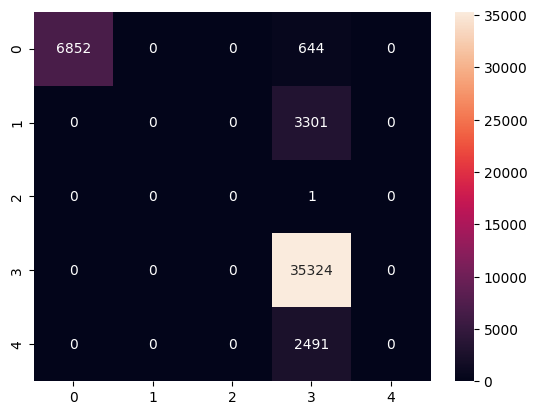

In [11]:
confusion_matrix(y_test["new_labels"], preds.round())
sns.heatmap(confusion_matrix(y_test["new_labels"], preds.round()), annot=True, fmt="d")

Performance are pretty good as we achieve 86% of accuracy on the test dataset

Let's see which feature is the most important

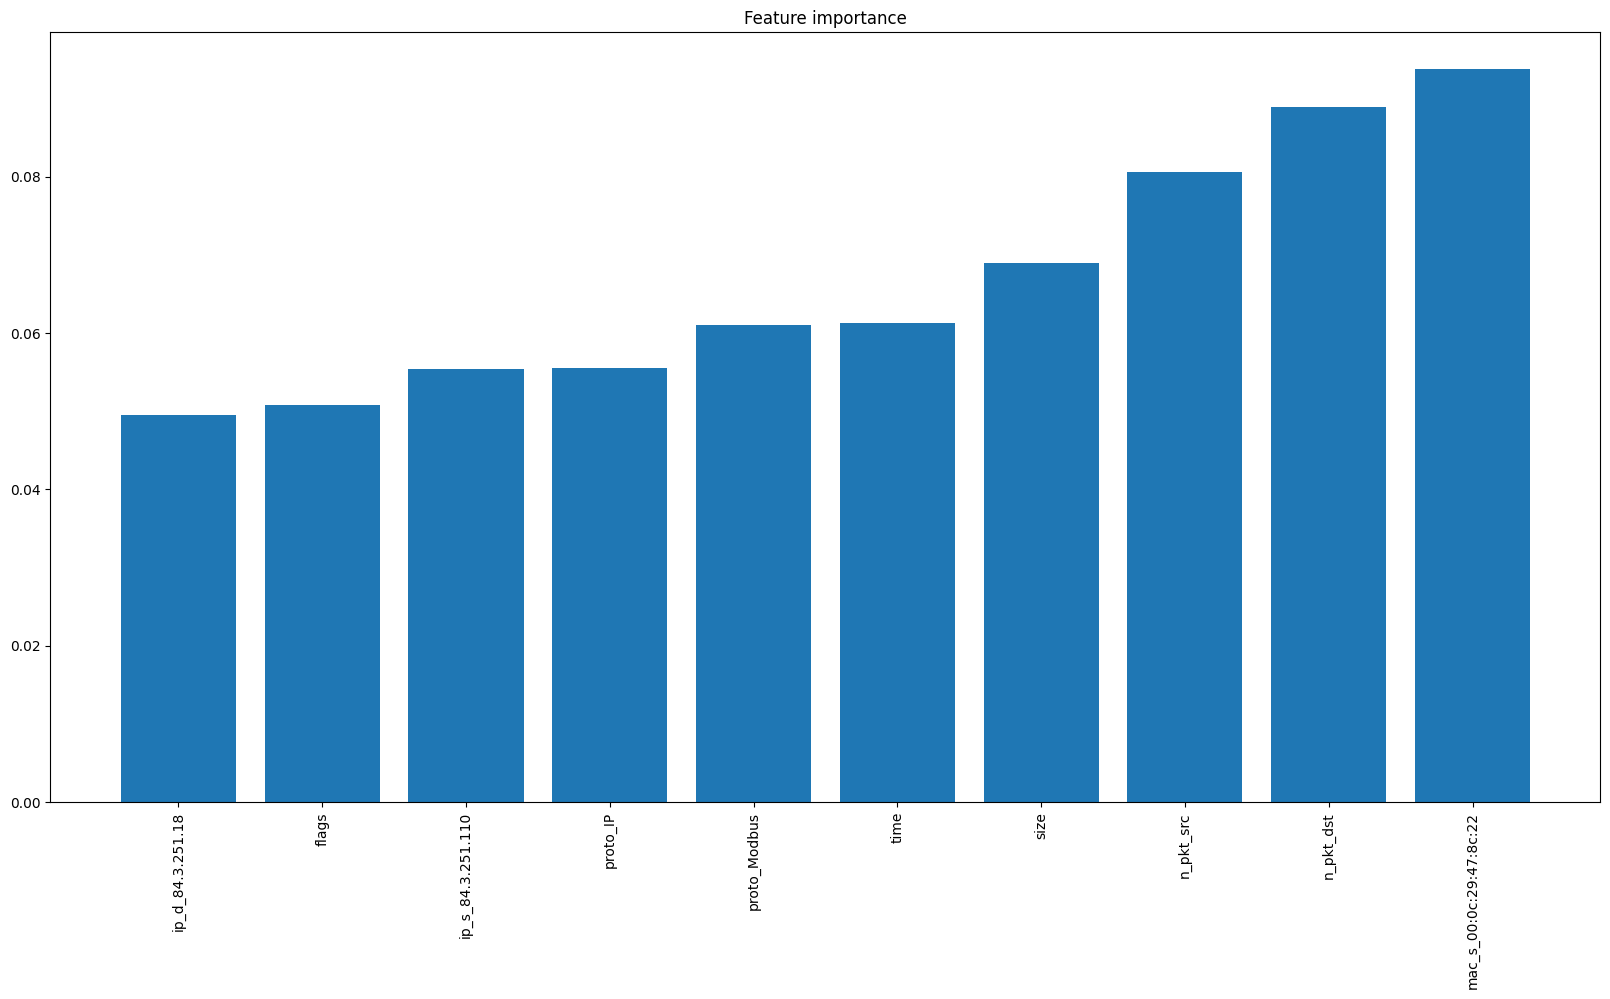

In [12]:
# plot feature importance
importance = rf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()

### Without contextual features

In [13]:
df_network_no_context = remove_network_contextual_columns(df_network)
df_network_no_context

,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,label_n,label,attack
0,56666.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
1,502.0,56666.0,Modbus,11000.0,64,Read Coils Response,15.0,50.0,0,normal,1
2,56668.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,1
3,502.0,56668.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
4,502.0,56666.0,Modbus,11000.0,65,Read Holding Registers Response,15.0,50.0,0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...
243060,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243061,61516.0,502.0,Modbus,11000.0,66,Read Holding Registers,50.0,15.0,0,normal,0
243062,61517.0,502.0,Modbus,11000.0,66,Read Holding Registers,51.0,14.0,0,normal,0
243063,61515.0,502.0,Modbus,11000.0,66,Read Holding Registers,47.0,14.0,0,normal,0


In [14]:
df_network_prepared, df_network_labels = prepare_HTIL_network_dataset(df_network_no_context)
df_network_prepared.head()

,sport,dport,flags,size,n_pkt_src,n_pkt_dst,proto_ARP,proto_ICMP,proto_IP,proto_Modbus,proto_TCP,modbus_fn_,modbus_fn_Read Coils Request,modbus_fn_Read Coils Response,modbus_fn_Read Holding Registers,modbus_fn_Read Holding Registers Response
0,56666.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
1,502.0,56666.0,11000.0,64,15.0,50.0,0,0,0,1,0,0,0,1,0,0
2,56668.0,502.0,11000.0,66,50.0,15.0,0,0,0,1,0,0,0,0,1,0
3,502.0,56668.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1
4,502.0,56666.0,11000.0,65,15.0,50.0,0,0,0,1,0,0,0,0,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_network_prepared, df_network_labels[["new_labels", "label_n"]], test_size=0.2, random_state=random_state)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((194452, 16), (48613, 16), (194452, 2), (48613, 2))

In [16]:
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'random_state': random_state,
    'n_jobs': -1,
}

rf = RandomForestClassifier(**params)

In [18]:
pipeline = make_pipeline(
    StandardScaler(),
    rf
)

pipeline.fit(X_train, y_train["new_labels"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_jobs=-1,
                                        random_state=42))])

In [19]:
preds = pipeline.predict(X_test)

In [20]:
print("Accuracy: ", accuracy_score(y_test["new_labels"], preds.round()))
print("Precision: ", precision_score(y_test["new_labels"], preds.round(), average="macro"))
print("Recall: ", recall_score(y_test["new_labels"], preds.round(), average="macro"))
print("F1: ", f1_score(y_test["new_labels"], preds.round(), average="macro"))
print("MCC: ", matthews_corrcoef(y_test["new_labels"], preds.round()))
print("Balanced accuracy: ", balanced_accuracy_score(y_test["new_labels"], preds.round()))

Accuracy:  0.8750334272725403
Precision:  0.3706035761779491
Recall:  0.39249700621670025
F1:  0.3803188596239753
MCC:  0.6989259906658432
Balanced accuracy:  0.39249700621670025


/Users/quentinfisch/Documents/EPITA/ING3/SCIA/S9/MLSECU/ML-SECU2024/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

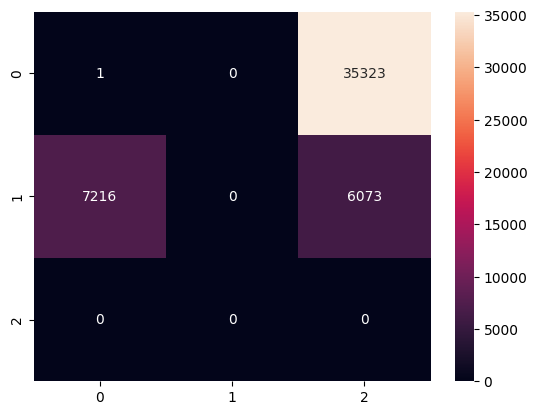

In [21]:
confusion_matrix(y_test["label_n"], preds.round())
sns.heatmap(confusion_matrix(y_test["label_n"], preds.round()), annot=True, fmt="d")

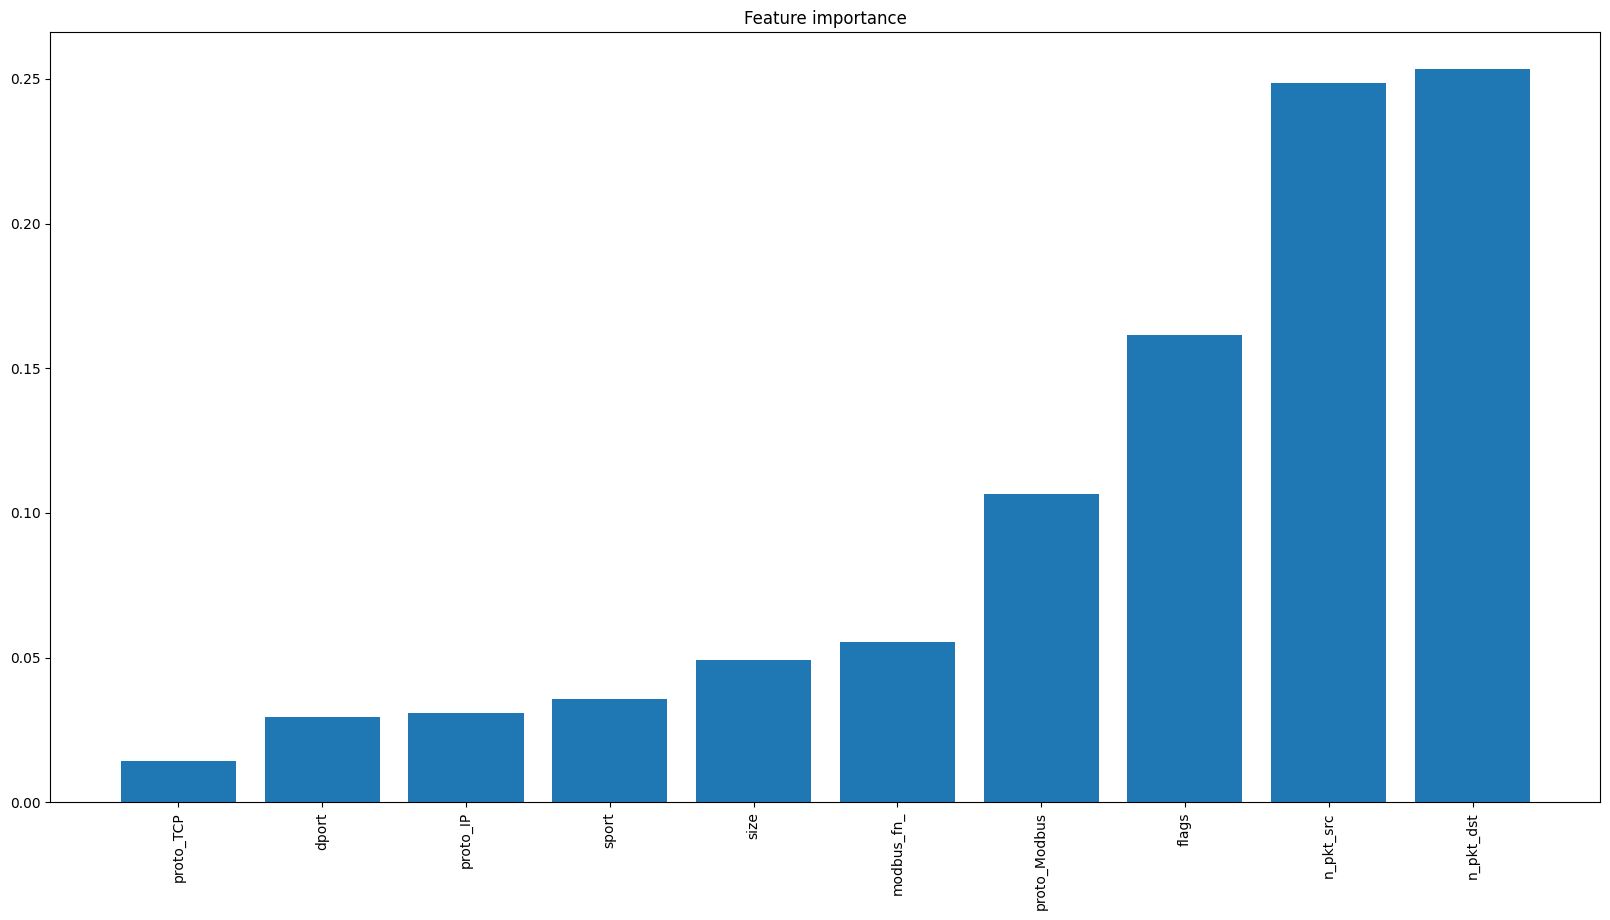

In [25]:
# plot feature importance
importance = rf.feature_importances_
# keep 10 most important features
idx = np.argsort(importance)[-10:]
importance = importance[idx]
# plot feature importance
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))], X_train.columns[idx], rotation='vertical')
plt.show()